In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from QRNN import QRNN

# --- Hyperparameters (match training) ---
N_QUBITS = 8
REPEAT_BLOCKS = 1
CONTEXT_LENGTH = 1
PREDICTION_HORIZON = 1
IN_DIM = 1
OUT_DIM = 2
SHOTS = 9000
BATCH_SIZE = 1

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# --- Load full Lorenz data ---
try:
    raw_data = np.load("train_data_lorenz_full.npy")
except FileNotFoundError:
    print("Error: 'train_data_lorenz_full.npy' not found.")
    raise

# Split into train/test
split_index = int(len(raw_data) * 0.7)
test_data = raw_data[split_index:]  # full test sequence

# Input = only the driving dimension (col 0)
# Labels = the prediction targets (col 1,2)
X_test = torch.tensor(test_data[:, 0], dtype=torch.float32).view(1, -1, 1).to(device)  # shape (1, seq_len, in_dim)
y_test = torch.tensor(test_data[:, 1:3], dtype=torch.float32).view(1, -1, OUT_DIM).to(device)


# --- Build context-windowed test sequence ---
inputs = []
labels = []
total_length = CONTEXT_LENGTH + PREDICTION_HORIZON

for i in range(len(test_data) - total_length + 1):
    # input = sliding window from first column
    window = test_data[i : i + CONTEXT_LENGTH, 0]
    inputs.append(window)

    # label = future target from columns 1:3
    label = test_data[i + CONTEXT_LENGTH + PREDICTION_HORIZON - 1, 1:3]
    labels.append(label)

inputs = inputs
labels = labels

X_test = torch.tensor(inputs, dtype=torch.float32).view(1, -1, CONTEXT_LENGTH * IN_DIM).to(device)
y_test = torch.tensor(labels, dtype=torch.float32).view(1, -1, OUT_DIM).to(device)

print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
#model.sequence_length = X_test.shape[1]

Using device: cpu
Test data shape: torch.Size([1, 2969, 1]), Labels shape: torch.Size([1, 2969, 2])


/var/folders/d7/5zdtyjdj6bqf_gtsn20v944c0000gn/T/ipykernel_3920/2305616030.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  X_test = torch.tensor(inputs, dtype=torch.float32).view(1, -1, CONTEXT_LENGTH * IN_DIM).to(device)


In [3]:


# --- Load pretrained model ---
checkpoint_path = "./checkpoints/lorenz_8_spsa-w_SIMPLE_1_1024_2_QRNN_1385_LAST.pth"   # adjust to your checkpoint
model = QRNN(
    n_qubits=N_QUBITS,
    repeat_blocks=REPEAT_BLOCKS,
    in_dim=IN_DIM,
    out_dim=OUT_DIM,
    context_length=CONTEXT_LENGTH,
    sequence_length=X_test.shape[1],   # we’ll set dynamically
    batch_size=BATCH_SIZE,
    grad_method="finite-diff",
    shots=SHOTS
).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"✅ Loaded checkpoint from {checkpoint_path}")


Params per timestep: 55
✅ Loaded checkpoint from ./checkpoints/lorenz_8_spsa-w_SIMPLE_1_1024_2_QRNN_1385_LAST.pth


In [4]:
#Print model weights
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

input_layer.weight: tensor([[-1.2252],
        [ 1.2693],
        [ 2.4071],
        [-1.9338],
        [-3.3584],
        [-1.5841],
        [-1.6950],
        [ 0.0266],
        [-1.1010],
        [-3.8304],
        [-1.0308],
        [ 2.0972],
        [-4.0065],
        [ 0.1348],
        [ 2.3975],
        [-3.1160],
        [ 2.9009],
        [ 0.5943],
        [ 3.2921],
        [-3.0841],
        [-0.5857],
        [-1.5007],
        [ 0.5589],
        [ 1.9159],
        [-1.9558],
        [ 1.4830],
        [-1.4627],
        [-3.8564],
        [-0.6993],
        [ 1.9575],
        [-0.5329],
        [ 3.0906],
        [ 1.4451],
        [ 1.6333],
        [-1.5329],
        [-0.3285],
        [ 0.2014],
        [ 0.7102],
        [ 2.7862],
        [-2.8851],
        [-0.5615],
        [-2.3091],
        [-1.8262],
        [-0.9550],
        [ 3.5865],
        [ 0.4876],
        [-1.2628],
        [ 1.2644],
        [-1.0659],
        [ 2.1262],
        [ 1.8786],
        [ 2

In [ ]:
print("Input shape:", X_test.shape)
print("Target shape:", y_test.shape)

# --- Run model on full test sequence ---
with torch.no_grad():
    preds,_ = model(X_test)

preds = preds.cpu().numpy()[0]   # (seq_len, out_dim)
y_true = y_test.cpu().numpy()[0]

print("Predictions shape:", preds.shape)
print("Targets shape:", y_true.shape)

# --- Plot results ---
timesteps = np.arange(len(y_true))

Input shape: torch.Size([1, 2969, 1])
Target shape: torch.Size([1, 2969, 2])


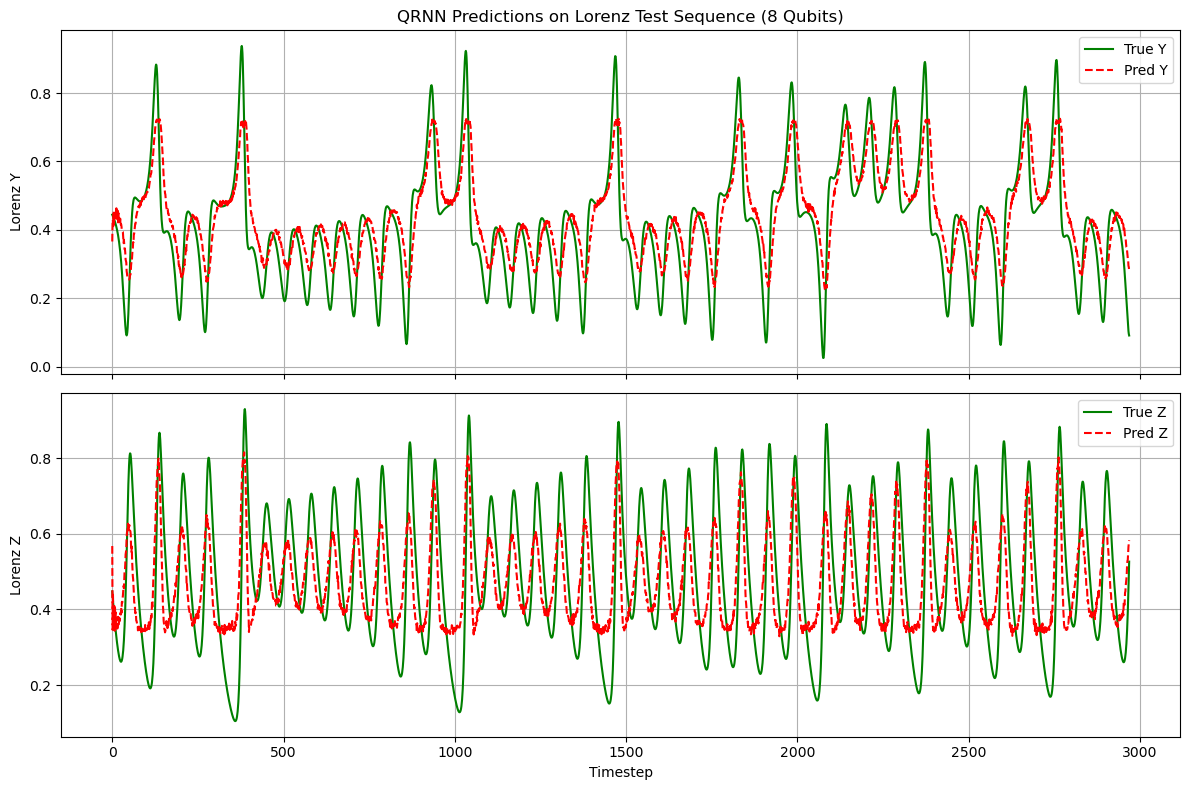

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Dimension 0 ---
axes[0].plot(timesteps, y_true[:, 0], label="True Y", color="green")
axes[0].plot(timesteps, preds[:, 0], "--", label="Pred Y", color="red")
axes[0].set_ylabel("Lorenz Y")
axes[0].set_title("QRNN Predictions on Lorenz Test Sequence (8 Qubits)")
axes[0].legend()
axes[0].grid(True)

# --- Dimension 1 ---
axes[1].plot(timesteps, y_true[:, 1], label="True Z", color="green")
axes[1].plot(timesteps, preds[:, 1], "--", label="Pred Z", color="red")
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Lorenz Z")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
#plt.savefig('../results/lorenz_qrnn_finite-diff_8qubits_1blocks_1epoch.pdf')
plt.show()


In [ ]:
#Compute RMSE
rmse_dim0 = np.sqrt(np.mean((y_true[:, 0] - preds[:, 0])**2))
rmse_dim1 = np.sqrt(np.mean((y_true[:, 1] - preds[:, 1])**2))
print(f"RMSE Dimension 0: {rmse_dim0:.6f}")
print(f"RMSE Dimension 1: {rmse_dim1:.6f}")
print(f"Average RMSE: {(rmse_dim0 + rmse_dim1) / 2:.6f}")


RMSE Dimension 0: 0.097856
RMSE Dimension 1: 0.132077
Average RMSE: 0.114967
